In [ ]:
#importing libraries
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plot
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from wordcloud import WordCloud
from textblob import Word
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#Loading the dataset
df = pd.read_csv("./imdb-reviews.csv", sep='\t')

In [ ]:
#Check for null values
#In this case there are no missing values
df.isnull().sum()

url       0
rating    0
review    0
dtype: int64

In [ ]:
#data preprocessing function
def preprocessing(review):
  review = review.lower()
  review = review.replace('http\S+|www.\S+|https\S+','') #removing urls
  review = review.replace('<br />', '') #removing <br>
  review = word_tokenize(review) #tokenization
  review = " ".join(review)

  review = ' '.join([word for word in review.split() if word not in punctuation])
  review = ' '.join([word for word in review.split() if word not in stop_words])
  review = ' '.join([word for word in review.split() if not word.isdigit()])

  review = ' '. join([word for word in review.split() if "'" not in word])
  review = ' '. join([word for word in review.split() if "`" not in word])

  return "".join(Word(word).lemmatize() for word in review)

In [ ]:
#adding boolean sentiment column to the dataset
df['sentiment'] = df['rating'] >=7


In [ ]:
df['review'] = df['review'].apply(preprocessing)

In [ ]:
df = df.drop_duplicates('review')

In [ ]:
#splitting dataset into training and validation data
training_data = df.sample(frac=0.8, random_state=25)
validation_data = df.drop(training_data.index)

In [ ]:
x_train = training_data['review']
y_train = training_data['sentiment']
x_val = validation_data['review']
y_val = validation_data['sentiment']

In [ ]:
#vectorizing
vec = TfidfVectorizer()
x_train = vec.fit_transform(x_train)

In [ ]:
x_val = vec.transform(x_val)

## **WordCloud**

In [ ]:
positive = training_data[training_data.rating >= 7]
negative = training_data[training_data.rating <= 4]

In [ ]:
text = ' '.join([word for word in positive['review']])
word_cloud = WordCloud(stopwords=stopwords.words('english'), max_words=500, width=1600, height=600).generate(text)

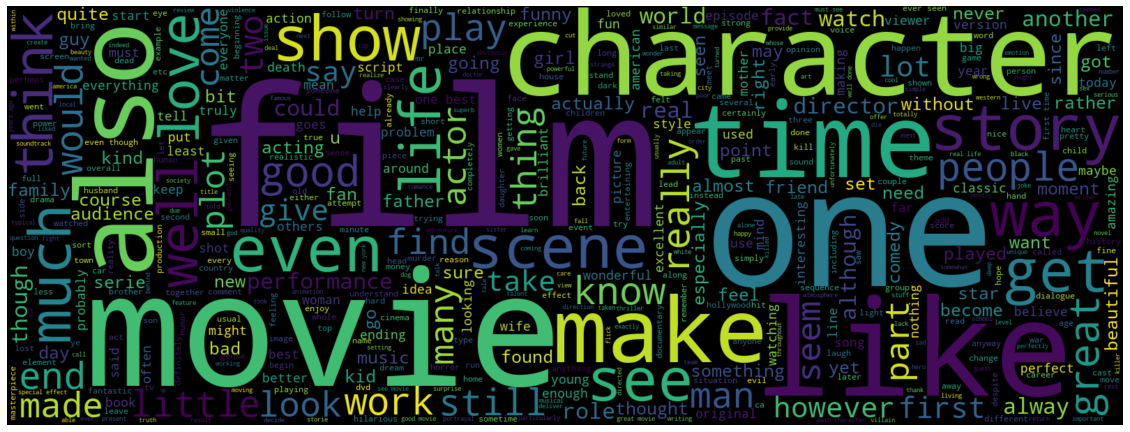

In [ ]:
plot.figure(figsize=(20,15))
plot.imshow(word_cloud, interpolation='bilinear')
plot.axis("off")
plot.show()

In [ ]:
text_neg = ' '.join([word for word in negative['review']])
word_cloud_neg = WordCloud(stopwords=stopwords.words('english'), max_words=500, width=1600, height=600).generate(text_neg)

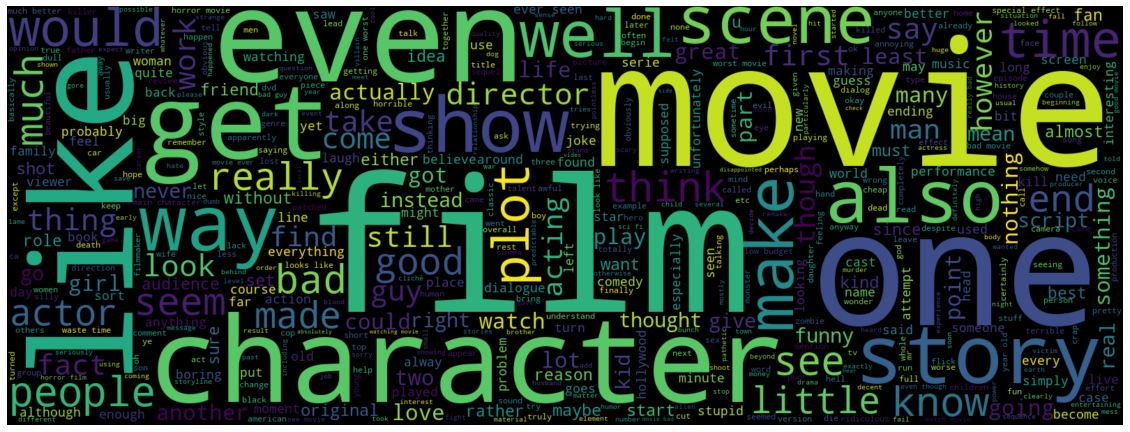

In [ ]:
plot.figure(figsize=(20,15))
plot.imshow(word_cloud_neg, interpolation='bilinear')
plot.axis("off")
plot.show()

In [ ]:
def word_counter(text):
  count = dict()
  words = text.split()
  for word in words:
    if word in count:
      count[word] += 1
    else:
      count[word] = 1
  return count

In [ ]:
count = word_counter(text)
print(count)

{'hunt': 170, 'justice': 327, 'setup': 33, 'slobadon': 1, 'milosevic': 4, 'trial': 119, 'hague': 5, 'little': 4560, 'clinical': 20, 'presentation': 107, 'subject': 586, 'matter': 899, 'could': 5124, 'gotten': 196, 'depressing': 135, 'quickly': 403, 'canadian': 146, 'judge': 263, 'louise': 56, 'arbour': 9, 'becomes': 1075, 'chief': 205, 'war': 1998, 'crimes': 95, 'prosecutor': 14, 'international': 236, 'criminal': 235, 'tribunal': 18, 'un': 31, 'yugoslavia': 16, 'battles': 109, 'everyone': 1758, 'pull': 249, 'evidence': 144, 'sent': 314, 'bad': 2616, 'docu-drama': 7, 'class': 562, 'directing': 386, 'production': 1114, 'work': 3092, 'disturbing': 378, 'shear': 8, 'discussion': 89, 'facts': 148, 'happily': 94, 'go': 3363, 'much': 6605, 'detail': 305, 'real': 3524, 'pictures': 317, 'tortured': 89, 'monkey': 85, 'surely': 257, 'one': 19029, 'best': 6030, 'shows': 2010, 'ever': 3814, 'shown': 781, 'tv': 1855, 'remember': 1280, 'kid': 715, 'grandma': 33, 'house': 1343, 'every': 2859, 'saturda

In [ ]:
count = word_counter(text_neg)
print(count)

{'film': 26108, 'incredibly': 520, 'bad': 10283, 'almost': 2221, 'felt': 1125, 'sick': 408, 'watching': 3815, 'point': 2529, 'installments': 11, 'least': 2873, 'one': 17771, 'good': 10143, 'thing': 4135, 'part': 2684, 'suspenseful': 90, 'gory': 216, 'beat': 232, 'entertaining': 815, 'interesting': 2303, 'great': 3621, 'effects': 2049, 'music': 1773, 'special': 1647, 'new': 2464, 'freddy': 148, 'krueger': 31, 'boring': 2090, 'anything': 2614, 'ever': 4673, 'seen': 4679, 'alice': 117, 'much': 7083, 'prettier': 8, 'blond': 88, 'back': 3244, 'boyfriend': 314, 'dan': 111, 'parts': 778, 'supposed': 1646, 'elm': 51, 'street': 378, 'installment': 71, 'turns': 782, 'daytime': 40, 'soap': 208, 'newer': 25, 'characters': 5174, 'seem': 1636, 'harsh': 121, 'even': 10872, 'sweet': 198, 'chip': 29, 'shoulder': 45, 'seems': 2846, 'completely': 1723, 'looks': 2087, 'tired': 352, 'gruesome': 130, 'one-liners': 90, 'place': 1589, 'different': 1200, 'could': 8201, 'pretty': 2978, 'funny': 3230, 'leslie': 

## **Hyperparameter tuning**

In [ ]:
#this step takes too much time, I ran it only once to get the best parameters
def hyperparameter_tuning(x_train, y_train):
  clf = GridSearchCV(LogisticRegression(max_iter=2000), {
      'C': [100, 10, 1.0, 0.1, 0.01],
      'penalty': ['none', 'l1', 'l2', 'elasticnet'],
      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']
  }, cv=5, return_train_score=False)
  clf.fit(x_train, y_train)
  clf.cv_results_
  return clf

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

{'mean_fit_time': array([5.97302537e+00, 2.32640562e+00, 1.61149979e-02, 7.67419501e+01,
        1.24155045e-02, 1.10560417e-02, 1.49444966e+00, 1.12541676e-02,
        5.19526215e+00, 8.58926301e+00, 3.79683571e+00, 1.08172057e+01,
        1.21273994e-02, 1.20393753e-02, 1.19701862e-02, 1.20357037e-02,
        6.11712184e+00, 2.29907675e+00, 1.38100624e-02, 7.73176748e+01,
        1.12087250e-02, 1.09022141e-02, 1.77779617e+00, 1.11556530e-02,
        4.38200784e+00, 6.08541851e+00, 2.43396912e+00, 2.01540451e+00,
        1.13484383e-02, 1.11104012e-02, 1.13085747e-02, 1.12435818e-02,
        6.07674212e+00, 2.50157380e+00, 1.39144421e-02, 7.40437383e+01,
        1.24314308e-02, 1.11794949e-02, 6.04458332e-01, 1.10482216e-02,
        3.16872883e+00, 3.72400289e+00, 1.26583533e+00, 1.18030295e+00,
        1.16439819e-02, 1.20610714e-02, 1.22680664e-02, 1.16436958e-02,
        5.77166729e+00, 2.25063033e+00, 1.34422779e-02, 7.43279722e+01,
        1.15629196e-02, 1.11187935e-02, 5.39203

In [ ]:
clas = hyperparameter_tuning(x_train, y_train)
clas.best_params_

{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}

In [ ]:
clas.best_score_

0.8989979688075348

## **Experimenting**

In [ ]:
regression = LogisticRegression(C=10, penalty='l2', solver='newton-cg',max_iter=2000)
regression.fit(x_train, y_train)
prediction = regression.predict(x_val)
print(classification_report(prediction, y_val))
accuracy = accuracy_score(prediction, y_val)
print("accuracy = {:.2f}%".format(accuracy*100))

              precision    recall  f1-score   support

       False       0.89      0.91      0.90      4410
        True       0.91      0.89      0.90      4523

    accuracy                           0.90      8933
   macro avg       0.90      0.90      0.90      8933
weighted avg       0.90      0.90      0.90      8933

accuracy = 90.14%


F1 Score Train: 1.0
F1 Score Validation: 0.6644240113627868
F1 Score Train: 0.9680644265481811
F1 Score Validation: 0.8633506121098489
F1 Score Train: 0.954570184983678
F1 Score Validation: 0.8775956284153006
F1 Score Train: 0.9466813752528038
F1 Score Validation: 0.8819711802881971
F1 Score Train: 0.9454166666666667
F1 Score Validation: 0.8892317866196408
F1 Score Train: 0.9434190287848824
F1 Score Validation: 0.8908306603251852
F1 Score Train: 0.9417705100291843
F1 Score Validation: 0.8941934051293438
F1 Score Train: 0.9419598880964576
F1 Score Validation: 0.8950863213811422
F1 Score Train: 0.9408687271976321
F1 Score Validation: 0.8961312493071723
F1 Score Train: 0.9394310936733693
F1 Score Validation: 0.8976150859678313


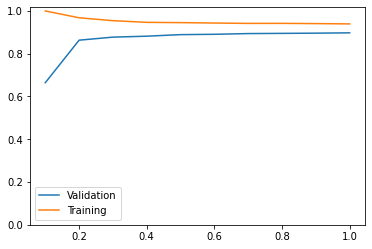

In [ ]:
list_f1=[]
list_f1_train=[]
list_sample_size=[]

for times in range(10):
  # training
  #
  X, X_unused, y, y_unused = train_test_split(x_train, y_train, test_size=1 - (times * 0.1 + 0.001))

  classifier = LogisticRegression(penalty='l2', solver='newton-cg', max_iter=2000)
  classifier.fit(X, np.ravel(y))

  results_train = classifier.predict(X)

  # validation
  #
  results = classifier.predict(x_val)

  # score
  #
  f1_train = f1_score(y, results_train)
  print("F1 Score Train: " + str(f1_train))

  f1 = f1_score(y_val, results)
  print("F1 Score Validation: " + str(f1))

  list_f1.append(f1)
  list_f1_train.append(f1_train)
  list_sample_size.append((times * 0.1 + 0.1))

# print(plot_data)
plot.plot(list_sample_size, list_f1)
plot.plot(list_sample_size, list_f1_train)

plot.ylim(ymin=0)
plot.legend(["Validation", "Training"])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision Score: 0.0
Precision Score: 0.8510546706844597
Precision Score: 0.8506013926988816
Precision Score: 0.8605995717344753
Precision Score: 0.8675112733519433
Precision Score: 0.875
Precision Score: 0.8742424242424243
Precision Score: 0.881218496603112
Precision Score: 0.8842704003500328
Precision Score: 0.8873517786561265


Text(0.5, 1.0, 'Precision')

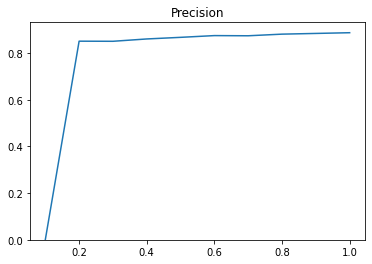

In [ ]:
list_precision=[]
list_sample_size=[]

for times in range(10):
  # training
  #
  X, X_unused, y, y_unused = train_test_split(x_train, y_train, test_size=1 - (times * 0.1 + 0.001))

  classifier = LogisticRegression(penalty='l2', solver='newton-cg', max_iter=2000)
  classifier.fit(X, np.ravel(y))

  results_train = classifier.predict(X)

  # validation
  #
  results = classifier.predict(x_val)

  # precision

  precision = precision_score(y_val, results)
  print("Precision Score: " + str(precision))

  list_precision.append(precision)
  list_sample_size.append((times * 0.1 + 0.1))

plot.plot(list_sample_size, list_precision)

plot.ylim(ymin=0)
plot.title("Precision")

Recall Score: 0.0009000900090009
Recall Score: 0.8841134113411341
Recall Score: 0.8892889288928892
Recall Score: 0.8996399639963997
Recall Score: 0.9090909090909091
Recall Score: 0.9079657965796579
Recall Score: 0.9061656165616562
Recall Score: 0.9104410441044104
Recall Score: 0.9104410441044104
Recall Score: 0.9104410441044104


Text(0.5, 1.0, 'Recall')

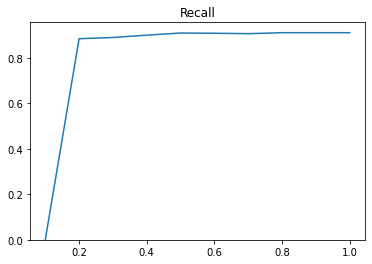

In [ ]:
list_recall=[]
list_sample_size=[]

for times in range(10):
  # training
  #
  X, X_unused, y, y_unused = train_test_split(x_train, y_train, test_size=1 - (times * 0.1 + 0.001))

  classifier = LogisticRegression(penalty='l2', solver='newton-cg', max_iter=2000)
  classifier.fit(X, np.ravel(y))

  results_train = classifier.predict(X)

  # validation
  #
  results = classifier.predict(x_val)

  # precision

  recall = recall_score(y_val, results)
  print("Recall Score: " + str(recall))

  list_recall.append(recall)
  list_sample_size.append((times * 0.1 + 0.1))

# print(plot_data)
plot.plot(list_sample_size, list_recall)

plot.ylim(ymin=0)
plot.title("Recall")

In [ ]:
predictions_train = classifier.predict(x_train)
predictions_val = classifier.predict(x_val)

print(predictions_val)
print(np.ravel(y_val))

print(predictions_val.sum())
print(np.ravel(y_val).sum())

# F-Score

f1_train = f1_score(y_train, predictions_train)
f1_val = f1_score(y_val, predictions_val)

print("F1 Score (train):", f1_train)
print("F1 Score (validation):", f1_val)

[ True False  True ...  True  True False]
[ True False  True ...  True  True False]
4572
4444
F1 Score (train): 0.9357615894039736
F1 Score (validation): 0.8975155279503105


**You can use this last section to test the project**

In [ ]:
#testing
df_test = pd.read_csv("put the name of the test set here", sep='\t')

df_test['sentiment'] = df_test['rating'] >=7
df_test['review'] = df_test['review'].apply(preprocessing)
df_test = df_test.drop_duplicates('review')

x_test = df_test['review']
y_test = df_test['sentiment']

x_test = vec.transform(x_test)

regression = LogisticRegression(C=10, penalty='l2', solver='newton-cg',max_iter=2000)
regression.fit(x_train, y_train)
prediction = regression.predict(x_test)
print(classification_report(prediction, y_test))
accuracy = accuracy_score(prediction, y_test)
print("accuracy = {:.2f}%".format(accuracy*100))